In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import colorednoise as cn
import qutip as qt
from noise_generator import GenerateNoise
import numpy as np

In [69]:
sample_rate = 1               # per ns
tnoise_max = int(1e5)             # number of samples
omega_ir = 1/tnoise_max*2*np.pi
S0 = 1e-3
relative_PSD_strength = S0**2
num_realizations = 1000
ifwhite = False              # True for white noise, False for 1/f noise
# Generate white noise (unit variance) trajectories
N = tnoise_max * sample_rate
gn = GenerateNoise(sample_rate, tnoise_max, relative_PSD_strength, num_realizations, ifwhite)

In [70]:
trajs = gn.generate_colored_noise()

Sanity Checks (1/f noise):
PSD fit: power = -1.0001, intercept = -6.5597, R² = 0.9990, S0 = 2.094356e-04


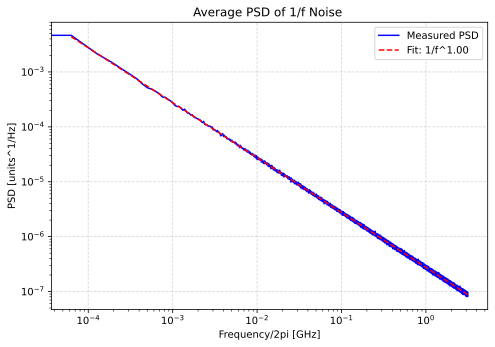

In [71]:
S0 = gn.analyze_noise_psd(trajs)

In [58]:
from hamiltonian_generator import Hamiltonian
import qutip as qt


phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
H_control = qt.Qobj(sc.H_control)
A = 5e-3 * 2 * np.pi
optimal_omega = sc.optimal_omegad(A)[0]*2*np.pi

sc = Hamiltonian(phi_ex, Ej, Ec, [2,1])
H0_matrix = sc.H
first_element = H0_matrix[0, 0]
for i in range(H0_matrix.shape[0]):
    H0_matrix[i, i] -= first_element
H0 = qt.Qobj(H0_matrix)
H_control = qt.Qobj(sc.H_control)
# Make diagonal term subtract the first element
noise_matrix = sc.noise.copy()
first_element = noise_matrix[0, 0]
for i in range(noise_matrix.shape[0]):
    noise_matrix[i, i] -= first_element
noise = noise_matrix/noise_matrix[1,1]
noise = qt.Qobj(noise)
A = 0


In [59]:
noise

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.00000000e+00 5.48805249e-16]
 [5.48805249e-16 1.00000000e+00]]

In [60]:
from system import *
from qutip import sesolve, basis, sigmaz, sigmax
def simulate_dynamics(A, initial_state):
    """
    Simulate quantum dynamics with noise trajectories.
    
    Parameters:
    -----------
    A : float
        Control amplitude
    initial_state : qutip.Qobj
        Initial quantum state
    H0 : qutip.Qobj
        Base Hamiltonian
    H_control : qutip.Qobj
        Control Hamiltonian
    noise : qutip.Qobj
        Noise operator
    optimal_omega : float
        Optimal frequency for rotating frame
    trajs : ndarray
        Noise trajectories
    num_realizations : int
        Number of noise realizations
    sample_rate : float
        Sampling rate for time points
        
    Returns:
    --------
    ndarray
        Average expectation values over all trajectories
    """

    
    # Diagonalize the rotating frame Hamiltonian
    H0_rot = H0.full() - optimal_omega * np.diag(np.arange(H0.shape[0])) + A/2 * H_control.full()
    
    evals_rot, U_diag = np.linalg.eigh(H0_rot)
    evals_rot, U_diag = sort_eigenpairs(evals_rot, U_diag)
    Ud_diag = U_diag.T.conj()
    H_diag = qt.Qobj(np.diag(evals_rot))  # Diagonal Hamiltonian
    noise_ro = Ud_diag @ noise.full() @ U_diag
    noise_ro = qt.Qobj(noise_ro)
    H0_rot = H_diag
    
    # Initialize arrays to store results
    all_expect_values = []
    t_max = 1000
    N = t_max
    time_points = np.linspace(0, t_max, N)  # Time points matching noise trajectory
    
    dim = noise.shape[0]
    # Loop through each noise trajectory
    for i in range(num_realizations):
        # Create time-dependent Hamiltonian with noise
        H = [H0_rot, [noise_ro, lambda t, args: trajs[i][int(t * sample_rate)] if t < t_max else 0]]
        
        # Solve the dynamics
        result = sesolve(H, initial_state, time_points)
        # Calculate projector averages for each time point
        avg_values = np.zeros((3, len(time_points)))  # Only need 2 states for basis(2,0) and basis(2,1)
        for j, t in enumerate(time_points):
            # Get the state at time t
            state_t = result.states[j]
            # Calculate expectation values for |0⟩⟨0| and |1⟩⟨1| projectors
            avg_values[0, j] = qt.expect(qt.basis(2, 0) * qt.basis(2, 0).dag(), state_t)
            avg_values[1, j] = qt.expect(qt.basis(2, 1) * qt.basis(2, 1).dag(), state_t)
            avg_values[2, j] = qt.expect(qt.sigmax(), state_t)
        # Store the expectation values for both projectors
        all_expect_values.append(avg_values)
    
    # Convert to numpy array for easier analysis
    all_expect_values = np.array(all_expect_values)
    
    
    return all_expect_values

In [61]:
A = 0
initial_state = (qt.basis(2, 0) + qt.basis(2, 1))/np.sqrt(2)
all_expect_values = simulate_dynamics(A,initial_state)
avg_expect_values = np.mean(all_expect_values, axis=0)

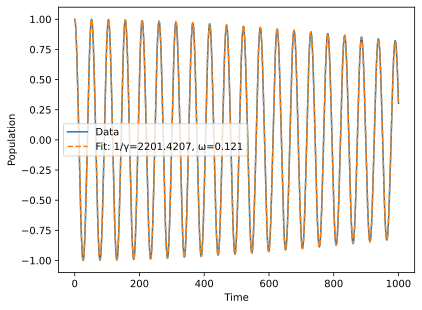

In [62]:
from scipy.optimize import curve_fit

def fit_func(t, gamma, omega):
    return np.exp(-gamma**2 * t**2) * np.cos(omega * t)

# Get time points
t = np.linspace(0, 1000, 1000)

# Get initial guess for omega from H_rot
omega_guess = 0.1

# Fit the data with initial guesses
popt, _ = curve_fit(fit_func, t, avg_expect_values[2], p0=[0.1, omega_guess])

# Plot original data and fit
plt.plot(t, avg_expect_values[2], label='Data')
plt.plot(t, fit_func(t, *popt), '--', label=f'Fit: 1/γ={1/popt[0]:.4f}, ω={popt[1]:.3f}')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()

In [63]:
A = 5e-3*2*np.pi
initial_state = qt.basis(2, 0) 
all_expect_values = simulate_dynamics(A,initial_state)
avg_expect_values = np.mean(all_expect_values, axis=0)

 /var/folders/nt/998zzxpj2632htnn_h4jz6n40000gn/T/ipykernel_12981/2985126689.py: 13

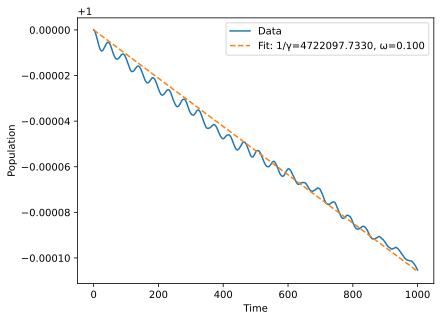

In [64]:
from scipy.optimize import curve_fit

def fit_func(t, gamma, omega):
    return 0.5+0.5*np.exp(-gamma * t) 

# Get time points
t = np.linspace(0, 1000, 1000)

# Get initial guess for omega from H_rot
omega_guess = 0.1

# Fit the data with initial guesses
popt, _ = curve_fit(fit_func, t, avg_expect_values[0], p0=[0.1, omega_guess])

# Plot original data and fit
plt.plot(t, avg_expect_values[0], label='Data')
plt.plot(t, fit_func(t, *popt), '--', label=f'Fit: 1/γ={1/popt[0]:.4f}, ω={popt[1]:.3f}')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()

In [155]:
4893631
200000

np.float64(0.6839397205857212)